# Практикум 3: Побудова композитних індикаторів

## Оцінка інноваційної активності країн світу

**Виконали:** Чижов Андрій, Гермаш Аліна, Забрудська Поліна

**Група:** КІ-33

---

## 1. Огляд рішень

Для оцінки інноваційної активності країн використовують міжнародні рейтинги:

| Індекс | Опис |
|--------|------|
| **Global Innovation Index (GII)** | Щорічний рейтинг, що оцінює інноваційний потенціал та результати інновацій у країнах світу |
| **Bloomberg Innovation Index** | Ранжує країни за інноваційними показниками: R&D, продуктивність, патенти |
| **European Innovation Scoreboard (EIS)** | Оцінює країни ЄС за різними аспектами інноваційної діяльності |

**Основні методи оцінки:**
- Використання агрегованих показників (зважена сума)
- Стандартизація показників (z-score) для об'єднання різнорідних даних
- Створення композитних індикаторів
- Аналіз головних компонент (PCA)

## 2. Концептуальна модель та підбір індикаторів

**Концептуальна модель:**

$$\text{Інноваційна активність} = f(\text{Ресурси} + \text{Виходи} + \text{Екосистема})$$

**Підібрані індикатори (6 показників):**

| Група | Показник | Скорочення | Джерело |
|-------|----------|------------|----------|
| **Ресурси** | R&D витрати (% ВВП) | R&D_pct_GDP | World Bank |
| **Ресурси** | Частка STEM-випускників (%) | STEM_pct | UNESCO |
| **Виходи** | Наукові публікації на 1 млн населення | Publications | Our World in Data |
| **Виходи** | Патенти на 1 млн населення | Patents_per_million | Our World in Data |
| **Екосистема** | Рання підприємницька активність TEA (%) | TEA_pct | GEM |
| **Екосистема** | Щільність нових бізнесів (на 1000 осіб 15-64) | New_Business_Density | World Bank |

**Розподіл ваг:**
- Ресурси: 30% (по 15% кожен показник)
- Виходи: 40% (по 20% кожен показник)
- Екосистема: 30% (по 15% кожен показник)

## 3. Пул об'єктів, заповнення пропусків та багатовимірний статистичний аналіз

**Параметри дослідження:**
- Пул об'єктів: **75 країн**
- Часовий період: **2005-2022 роки (18 років)**
- Загальна кількість спостережень: 75 × 18 = 1350

### 3.1 Завантаження бібліотек та даних

In [21]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)

print("Бібліотеки завантажено успішно")

Бібліотеки завантажено успішно


In [22]:
# Завантаження даних
df = pd.read_csv("raw_data_75.csv")

print("Інформація про датасет:")
print(f"  Розмір: {df.shape[0]} рядків × {df.shape[1]} стовпців")
print(f"  Кількість країн: {df['Country'].nunique()}")
print(f"  Часовий період: {df['Year'].min()} - {df['Year'].max()} ({df['Year'].max() - df['Year'].min() + 1} років)")

print("\nПерші 5 рядків датасету:")
df.head()

Інформація про датасет:
  Розмір: 1350 рядків × 9 стовпців
  Кількість країн: 75
  Часовий період: 2005 - 2022 (18 років)

Перші 5 рядків датасету:


,Country,Code,Year,Publications,R&D_pct_GDP,STEM_pct,Patents_per_million,TEA_pct,New_Business_Density
0,Algeria,DZA,2005,27.086,0.064,NaN,1.782,NaN,NaN
1,Algeria,DZA,2006,37.871,NaN,NaN,1.725,NaN,0.398
2,Algeria,DZA,2007,40.842,NaN,25.383,2.457,NaN,0.348
3,Algeria,DZA,2008,50.232,NaN,NaN,NaN,NaN,0.477
4,Algeria,DZA,2009,59.606,NaN,24.012,NaN,16.68,0.448


In [23]:
# Загальна інформація про дані
print("Структура даних:")
df.info()

Структура даних:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               1350 non-null   object 
 1   Code                  1350 non-null   object 
 2   Year                  1350 non-null   int64  
 3   Publications          1350 non-null   float64
 4   R&D_pct_GDP           1172 non-null   float64
 5   STEM_pct              904 non-null    float64
 6   Patents_per_million   1195 non-null   float64
 7   TEA_pct               738 non-null    float64
 8   New_Business_Density  1118 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 95.0+ KB


### 3.2 Заповнення пропусків

In [24]:
# Визначення числових колонок для аналізу
num_cols = ['Publications', 'R&D_pct_GDP', 'STEM_pct', 
            'Patents_per_million', 'TEA_pct', 'New_Business_Density']

# Аналіз пропусків
missing_info = pd.DataFrame({
    'Кількість пропусків': df[num_cols].isnull().sum(),
    'Відсоток (%)': (df[num_cols].isnull().sum() / len(df) * 100).round(2)
})

print("Аналіз пропусків у даних:")
print(missing_info)
print(f"\nЗагальна кількість пропусків: {df[num_cols].isnull().sum().sum()}")

Аналіз пропусків у даних:
                      Кількість пропусків  Відсоток (%)
Publications                            0          0.00
R&D_pct_GDP                           178         13.19
STEM_pct                              446         33.04
Patents_per_million                   155         11.48
TEA_pct                               612         45.33
New_Business_Density                  232         17.19

Загальна кількість пропусків: 1623


In [25]:
# Заповнення пропусків методом лінійної інтерполяції
df_filled = df.copy()

# Перетворення на числові типи
df_filled[num_cols] = df_filled[num_cols].apply(pd.to_numeric, errors='coerce')

# Лінійна інтерполяція по групах країн (Code)
df_filled[num_cols] = df_filled.groupby('Code')[num_cols].transform(
    lambda g: g.interpolate(method='linear', limit_direction='both')
)

# Заповнення залишкових пропусків на початку/кінці груп
df_filled[num_cols] = df_filled[num_cols].ffill().bfill()

print("Результати заповнення:")
print("  Пропуски після обробки:")
print(df_filled[num_cols].isnull().sum())
print("\n✓ Всі пропуски успішно заповнено")

# Збереження оброблених даних
import os
os.makedirs('raw_data', exist_ok=True)
os.makedirs('processed_data', exist_ok=True)
df.to_csv('raw_data/raw_data_75.csv', index=False)
df_filled.to_csv('processed_data/raw_data_filled.csv', index=False)
print("\n Файли збережено:")
print("   raw_data/raw_data_75.csv")
print("   processed_data/raw_data_filled.csv")

Результати заповнення:
  Пропуски після обробки:
Publications            0
R&D_pct_GDP             0
STEM_pct                0
Patents_per_million     0
TEA_pct                 0
New_Business_Density    0
dtype: int64

✓ Всі пропуски успішно заповнено

 Файли збережено:
   raw_data/raw_data_75.csv
   processed_data/raw_data_filled.csv


### 3.3 Багатовимірний статистичний аналіз

In [26]:
# Описова статистика
print("Описова статистика показників інноваційної активності:")
print("\n" + "="*80)
df_filled[num_cols].describe().round(2)

Описова статистика показників інноваційної активності:



,Publications,R&D_pct_GDP,STEM_pct,Patents_per_million,TEA_pct,New_Business_Density
count,1350.00,1350.00,1350.00,1350.00,1350.00,1350.00
mean,762.35,1.16,23.27,162.93,11.43,4.90
std,720.35,1.03,6.15,439.94,6.03,5.16
min,0.00,0.01,7.55,0.05,1.56,0.02
25%,119.40,0.34,19.09,12.10,6.67,1.21
50%,533.13,0.76,23.00,39.67,9.99,3.13
75%,1362.36,1.81,26.76,146.79,14.62,7.04
max,2881.05,6.02,45.46,3597.58,40.08,38.20


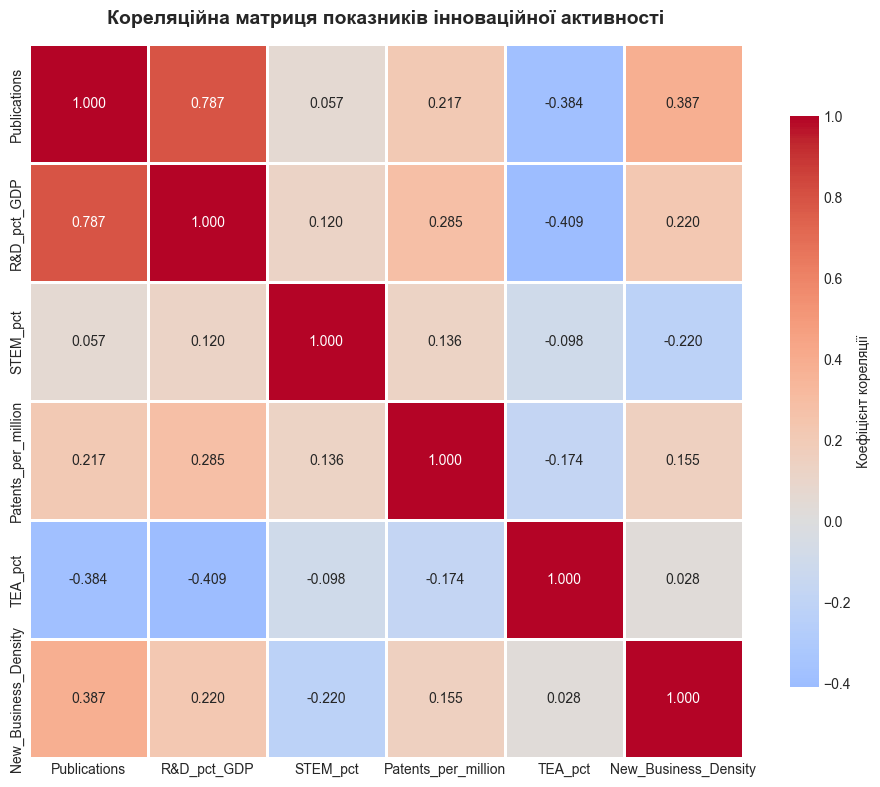


Кореляційна матриця:
                      Publications  R&D_pct_GDP  STEM_pct  \
Publications                 1.000        0.787     0.057   
R&D_pct_GDP                  0.787        1.000     0.120   
STEM_pct                     0.057        0.120     1.000   
Patents_per_million          0.217        0.285     0.136   
TEA_pct                     -0.384       -0.409    -0.098   
New_Business_Density         0.387        0.220    -0.220   

                      Patents_per_million  TEA_pct  New_Business_Density  
Publications                        0.217   -0.384                 0.387  
R&D_pct_GDP                         0.285   -0.409                 0.220  
STEM_pct                            0.136   -0.098                -0.220  
Patents_per_million                 1.000   -0.174                 0.155  
TEA_pct                            -0.174    1.000                 0.028  
New_Business_Density                0.155    0.028                 1.000  


In [27]:
# Кореляційний аналіз
corr_matrix = df_filled[num_cols].corr()

# Візуалізація кореляційної матриці
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, 
            cbar_kws={"shrink": 0.8, "label": "Коефіцієнт кореляції"})
plt.title('Кореляційна матриця показників інноваційної активності', 
          fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\nКореляційна матриця:")
print(corr_matrix.round(3))

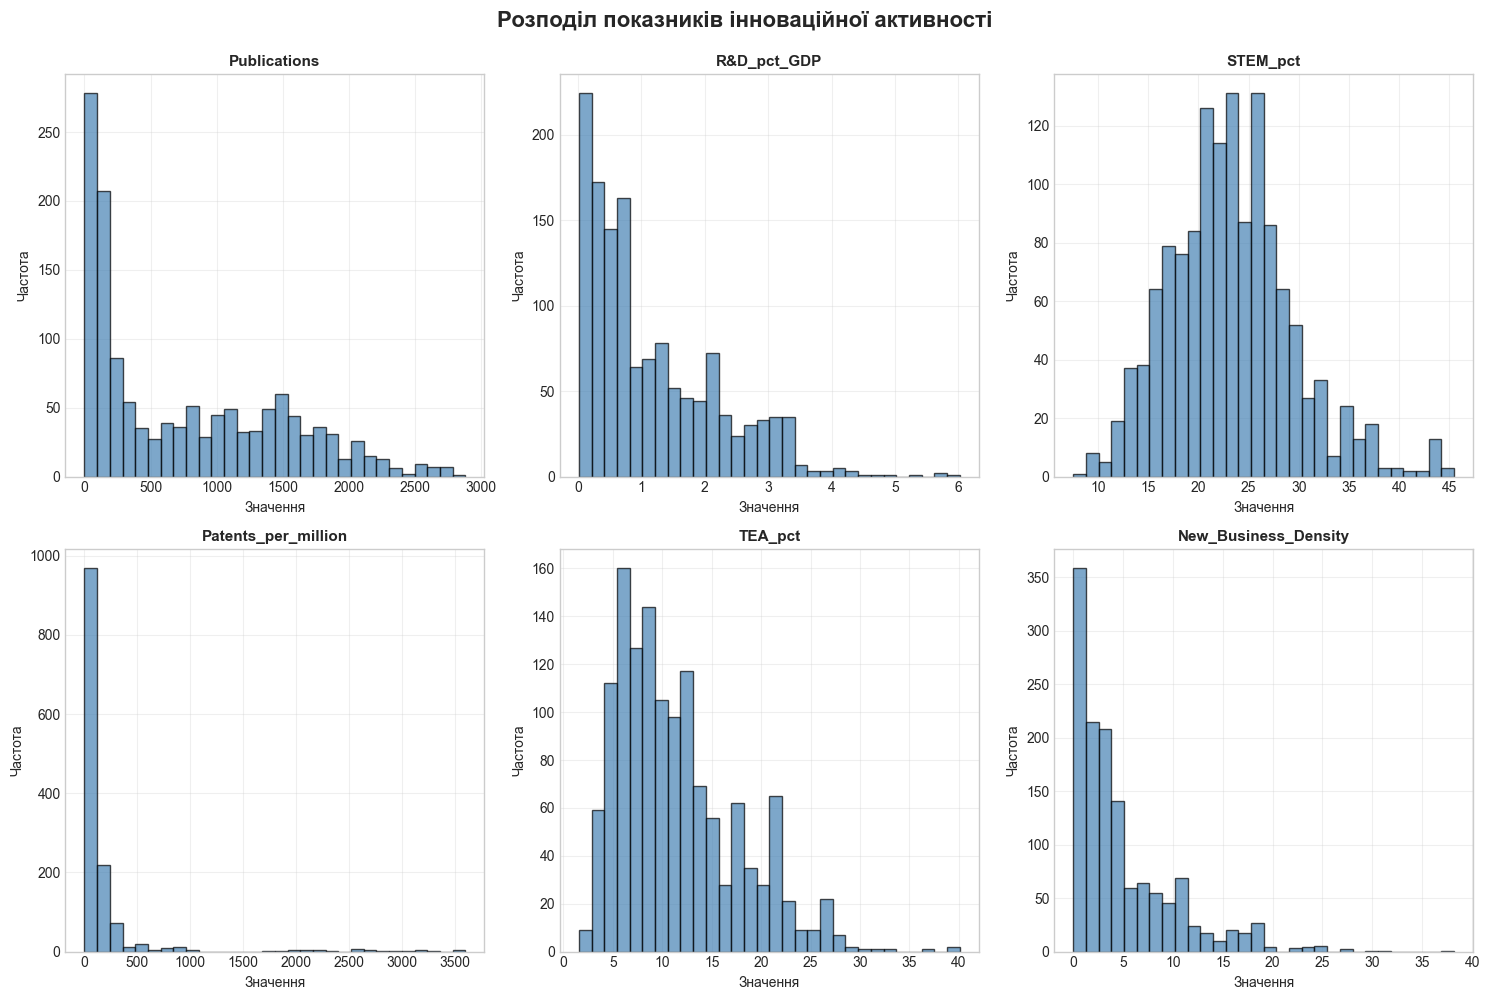

In [28]:
# Аналіз розподілів за допомогою гістограм
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    axes[idx].hist(df_filled[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Значення', fontsize=10)
    axes[idx].set_ylabel('Частота', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Розподіл показників інноваційної активності', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

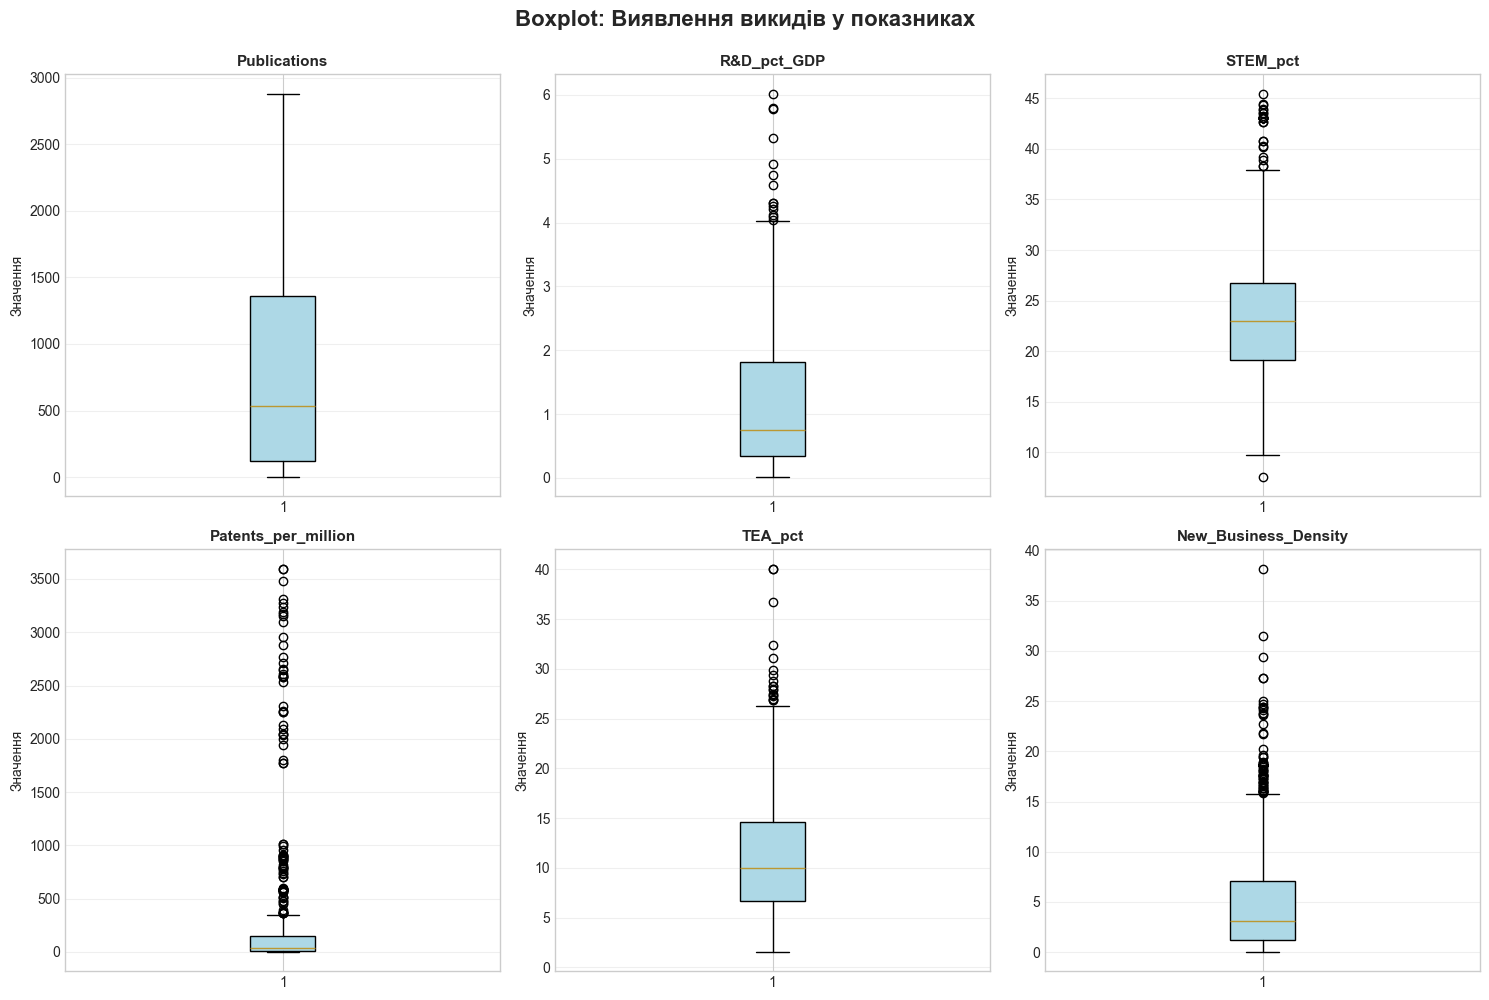

In [29]:
# Boxplot для виявлення викидів
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    bp = axes[idx].boxplot(df_filled[col].dropna(), patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Значення', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Boxplot: Виявлення викидів у показниках', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

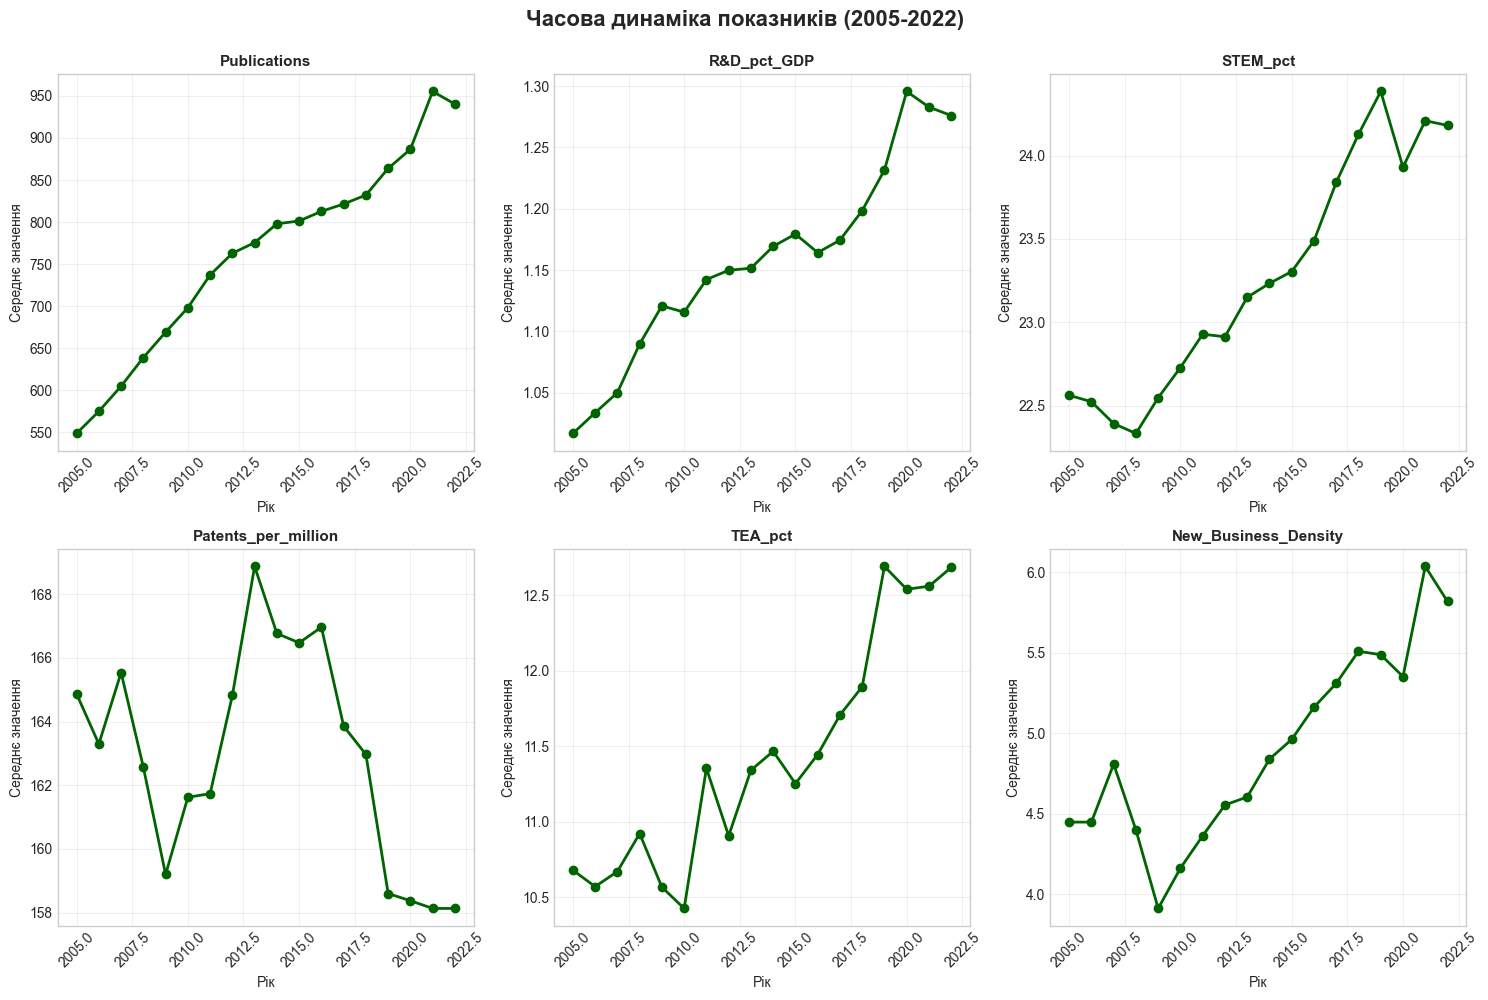

Висновок з часового аналізу:
  Проаналізовано динаміку змін показників інноваційної активності
  за 18-річний період для виявлення трендів та закономірностей.


In [30]:
# Часовий аналіз - динаміка середніх значень по роках
yearly_avg = df_filled.groupby('Year')[num_cols].mean()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    axes[idx].plot(yearly_avg.index, yearly_avg[col], marker='o', 
                   linewidth=2, markersize=6, color='darkgreen')
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Рік', fontsize=10)
    axes[idx].set_ylabel('Середнє значення', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Часова динаміка показників (2005-2022)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Висновок з часового аналізу:")
print("  Проаналізовано динаміку змін показників інноваційної активності")
print("  за 18-річний період для виявлення трендів та закономірностей.")

## 4. Нормалізація даних та побудова моделі

### 4.1 Нормалізація даних методом Z-score

In [31]:
# Стандартизація (Z-score нормалізація)
scaler = StandardScaler()
df_normalized = df_filled.copy()
df_normalized[num_cols] = scaler.fit_transform(df_filled[num_cols])

print("Нормалізація даних методом Z-score:")
print("\nФормула: z = (x - μ) / σ")
print("  де μ - середнє значення, σ - стандартне відхилення\n")

print("Перші 10 рядків нормалізованих даних:")
display(df_normalized[['Country', 'Year'] + num_cols].head(10))

print("\nПеревірка нормалізації:")
print("Середні значення (повинні бути ≈ 0):")
print(df_normalized[num_cols].mean().round(6))
print("\nСтандартні відхилення (повинні бути ≈ 1):")
print(df_normalized[num_cols].std().round(3))
print("\n Нормалізація виконана коректно")

Нормалізація даних методом Z-score:

Формула: z = (x - μ) / σ
  де μ - середнє значення, σ - стандартне відхилення

Перші 10 рядків нормалізованих даних:


,Country,Year,Publications,R&D_pct_GDP,STEM_pct,Patents_per_million,TEA_pct,New_Business_Density
0,Algeria,2005,-1.021,-1.064,0.344,-0.366,0.872,-0.873
1,Algeria,2006,-1.006,-1.030,0.344,-0.367,0.872,-0.873
2,Algeria,2007,-1.002,-0.997,0.344,-0.365,0.872,-0.882
3,Algeria,2008,-0.989,-0.963,0.233,-0.365,0.872,-0.857
4,Algeria,2009,-0.976,-0.929,0.121,-0.365,0.872,-0.863
5,Algeria,2010,-0.978,-0.896,0.873,-0.366,0.256,-0.873
6,Algeria,2011,-0.968,-0.862,0.384,-0.365,-0.359,-0.853
7,Algeria,2012,-0.948,-0.829,0.612,-0.363,-0.444,-0.842
8,Algeria,2013,-0.936,-0.795,0.839,-0.364,-1.084,-0.841
9,Algeria,2014,-0.931,-0.761,1.067,-0.365,-1.084,-0.832



Перевірка нормалізації:
Середні значення (повинні бути ≈ 0):
Publications            0.0
R&D_pct_GDP            -0.0
STEM_pct                0.0
Patents_per_million    -0.0
TEA_pct                 0.0
New_Business_Density    0.0
dtype: float64

Стандартні відхилення (повинні бути ≈ 1):
Publications            1.0
R&D_pct_GDP             1.0
STEM_pct                1.0
Patents_per_million     1.0
TEA_pct                 1.0
New_Business_Density    1.0
dtype: float64

 Нормалізація виконана коректно


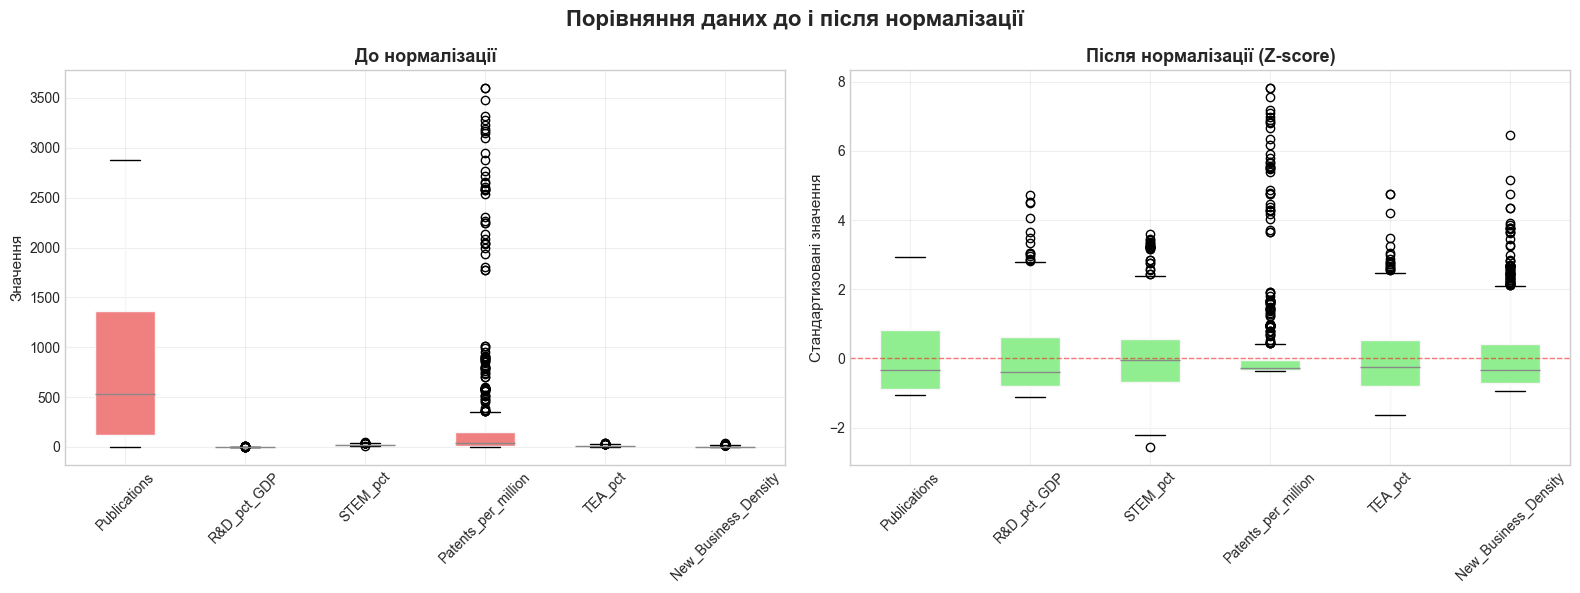

In [32]:
# Порівняння до та після нормалізації
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# До нормалізації
bp1 = df_filled[num_cols].boxplot(ax=ax1, patch_artist=True, return_type='dict')
for patch in bp1['boxes']:
    patch.set_facecolor('lightcoral')
ax1.set_title('До нормалізації', fontweight='bold', fontsize=13)
ax1.set_ylabel('Значення', fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Після нормалізації
bp2 = df_normalized[num_cols].boxplot(ax=ax2, patch_artist=True, return_type='dict')
for patch in bp2['boxes']:
    patch.set_facecolor('lightgreen')
ax2.set_title('Після нормалізації (Z-score)', fontweight='bold', fontsize=13)
ax2.set_ylabel('Стандартизовані значення', fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.suptitle('Порівняння даних до і після нормалізації', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 Побудова композитного індексу інноваційної активності

In [33]:
# Зважений композитний індекс
# Відповідно до концептуальної моделі: Ресурси (30%), Виходи (40%), Екосистема (30%)

weights = {
    'R&D_pct_GDP': 0.15,         # Ресурси
    'STEM_pct': 0.15,            # Ресурси
    'Publications': 0.20,        # Виходи
    'Patents_per_million': 0.20, # Виходи
    'TEA_pct': 0.15,             # Екосистема
    'New_Business_Density': 0.15 # Екосистема
}

print("Система ваг композитного індексу:")
print("\nГрупа показників та їх ваги:")
print("  Ресурси (30%):")
print("    - R&D_pct_GDP: 15%")
print("    - STEM_pct: 15%")
print("  Виходи (40%):")
print("    - Publications: 20%")
print("    - Patents_per_million: 20%")
print("  Екосистема (30%):")
print("    - TEA_pct: 15%")
print("    - New_Business_Density: 15%")
print(f"\nСума ваг: {sum(weights.values())*100:.0f}%")

# Обчислення композитного індексу
df_normalized['Innovation_Index'] = sum(
    df_normalized[col] * weight for col, weight in weights.items()
)

# Масштабування до діапазону 0-100
min_val = df_normalized['Innovation_Index'].min()
max_val = df_normalized['Innovation_Index'].max()
df_normalized['Innovation_Index_100'] = (
    (df_normalized['Innovation_Index'] - min_val) / (max_val - min_val) * 100
)

print("\n" + "="*80)
print("Статистика композитного індексу інноваційної активності:")
print("="*80)
print(df_normalized['Innovation_Index_100'].describe().round(2))
print("\n Композитний індекс успішно побудовано")

Система ваг композитного індексу:

Група показників та їх ваги:
  Ресурси (30%):
    - R&D_pct_GDP: 15%
    - STEM_pct: 15%
  Виходи (40%):
    - Publications: 20%
    - Patents_per_million: 20%
  Екосистема (30%):
    - TEA_pct: 15%
    - New_Business_Density: 15%

Сума ваг: 100%

Статистика композитного індексу інноваційної активності:
count    1350.00
mean       29.20
std        16.82
min         0.00
25%        16.57
50%        25.70
75%        39.99
max       100.00
Name: Innovation_Index_100, dtype: float64

 Композитний індекс успішно побудовано


### 4.3 Рейтинг країн за індексом інноваційної активності

In [34]:
# Обчислення середнього індексу по країнах за весь період
country_avg = df_normalized.groupby('Country')['Innovation_Index_100'].mean().sort_values(ascending=False)

print("РЕЙТИНГ КРАЇН ЗА ІНДЕКСОМ ІННОВАЦІЙНОЇ АКТИВНОСТІ")
print("(середнє значення за 2005-2022 роки)")
print("\n" + "="*60)
print("\nТоп-20 країн:")
print("="*60)

for i, (country, score) in enumerate(country_avg.head(20).items(), 1):
    print(f"{i:2d}. {country:30s} {score:6.2f}")

print("\n" + "="*60)
print(f"\nВсього країн у рейтингу: {len(country_avg)}")

РЕЙТИНГ КРАЇН ЗА ІНДЕКСОМ ІННОВАЦІЙНОЇ АКТИВНОСТІ
(середнє значення за 2005-2022 роки)


Топ-20 країн:
 1. South Korea                     85.79
 2. United States                   63.00
 3. Japan                           61.11
 4. Singapore                       57.70
 5. New Zealand                     55.79
 6. Sweden                          52.59
 7. Israel                          52.18
 8. Finland                         51.98
 9. Switzerland                     51.60
10. Germany                         50.67
11. Estonia                         50.00
12. Australia                       49.25
13. United Kingdom                  47.90
14. Denmark                         47.78
15. Iceland                         44.10
16. Austria                         43.81
17. Norway                          41.01
18. Canada                          38.79
19. Slovakia                        38.47
20. Luxembourg                      37.93


Всього країн у рейтингу: 75


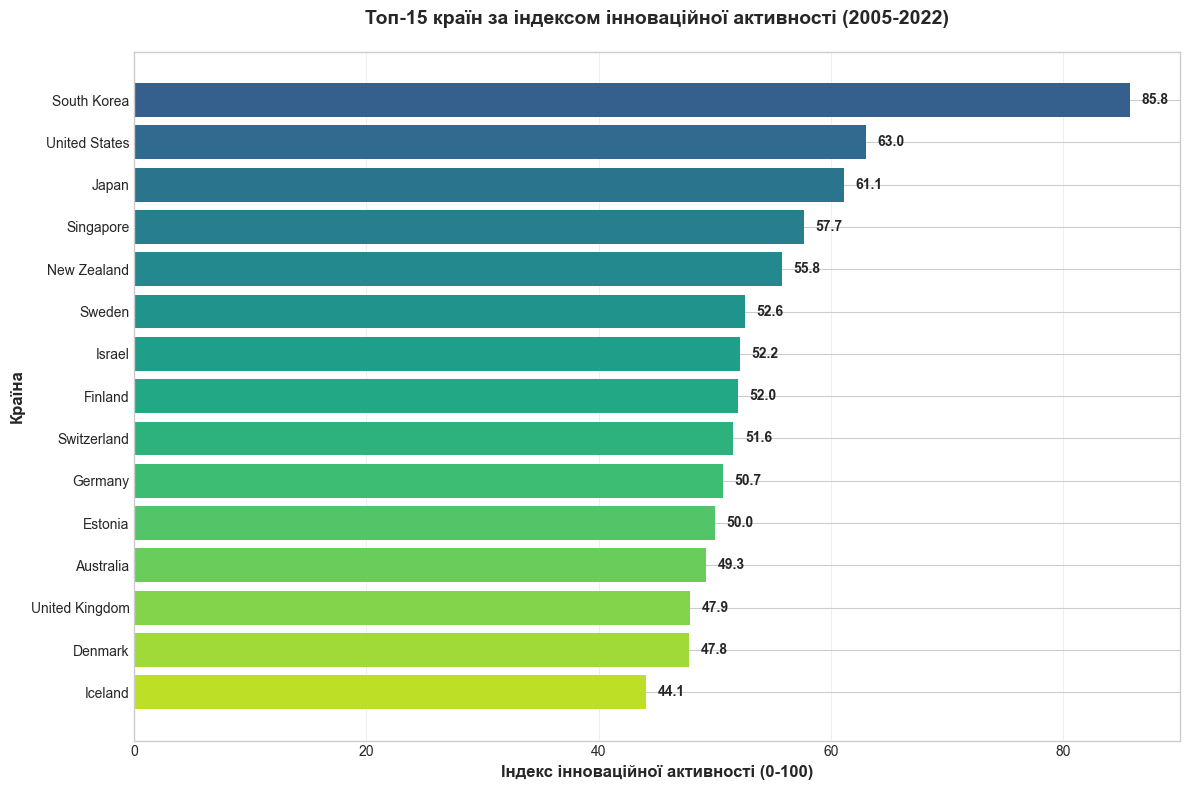

In [35]:
# Візуалізація топ-15 країн
plt.figure(figsize=(12, 8))
top15 = country_avg.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top15)))
bars = plt.barh(range(len(top15)), top15.values, color=colors)
plt.yticks(range(len(top15)), top15.index)
plt.xlabel('Індекс інноваційної активності (0-100)', fontsize=12, fontweight='bold')
plt.ylabel('Країна', fontsize=12, fontweight='bold')
plt.title('Топ-15 країн за індексом інноваційної активності (2005-2022)', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Додавання значень на графік
for i, (bar, value) in enumerate(zip(bars, top15.values)):
    plt.text(value + 1, i, f'{value:.1f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

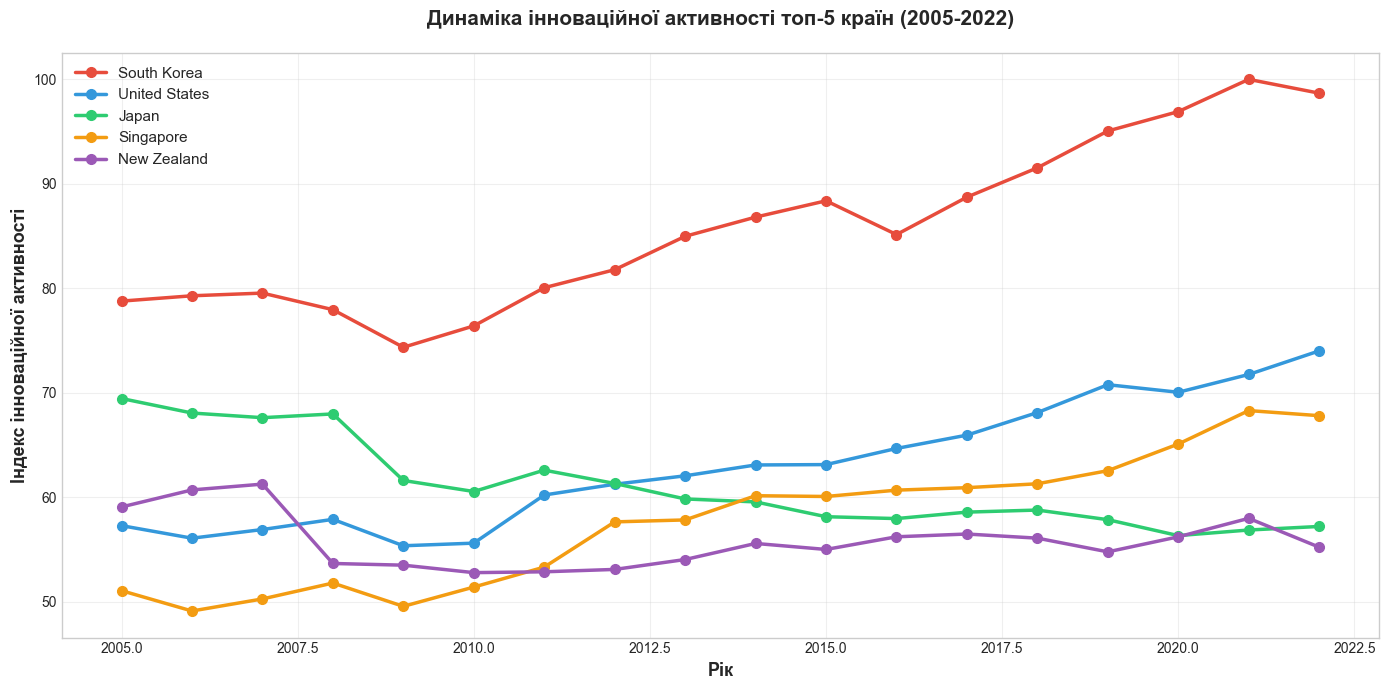

Висновок:
  Графік показує еволюцію інноваційної активності провідних країн
  протягом 18-річного періоду, що дозволяє виявити тренди та
  порівняти темпи розвитку інноваційних екосистем.


In [36]:
# Динаміка топ-5 країн протягом часу
top5_countries = country_avg.head(5).index.tolist()

plt.figure(figsize=(14, 7))
colors_line = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for country, color in zip(top5_countries, colors_line):
    country_data = df_normalized[df_normalized['Country'] == country]
    plt.plot(country_data['Year'], country_data['Innovation_Index_100'], 
            marker='o', linewidth=2.5, markersize=7, label=country, color=color)

plt.xlabel('Рік', fontsize=13, fontweight='bold')
plt.ylabel('Індекс інноваційної активності', fontsize=13, fontweight='bold')
plt.title('Динаміка інноваційної активності топ-5 країн (2005-2022)', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Висновок:")
print("  Графік показує еволюцію інноваційної активності провідних країн")
print("  протягом 18-річного періоду, що дозволяє виявити тренди та")
print("  порівняти темпи розвитку інноваційних екосистем.")

### 4.4 Аналіз головних компонент (PCA)

In [37]:
# Застосування PCA для аналізу структури даних
pca = PCA(n_components=len(num_cols))
pca_result = pca.fit_transform(df_normalized[num_cols])

# Пояснена дисперсія
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("АНАЛІЗ ГОЛОВНИХ КОМПОНЕНТ (PCA)")
print("\nПояснена дисперсія головних компонент:")
print("=" * 60)
print(f"{'Компонента':<15} {'Індивідуальна':<18} {'Кумулятивна':<15}")
print("=" * 60)

for i, (var, cum) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i:<13} {var*100:>10.2f}%         {cum*100:>10.2f}%")

print("=" * 60)
print(f"\nВисновок:")
print(f"  Перші 2 компоненти пояснюють {cumulative_variance[1]*100:.2f}% дисперсії")
print(f"  Перші 3 компоненти пояснюють {cumulative_variance[2]*100:.2f}% дисперсії")

АНАЛІЗ ГОЛОВНИХ КОМПОНЕНТ (PCA)

Пояснена дисперсія головних компонент:
Компонента      Індивідуальна      Кумулятивна    
PC1                  39.01%              39.01%
PC2                  21.19%              60.20%
PC3                  15.21%              75.41%
PC4                  12.66%              88.07%
PC5                   8.80%              96.87%
PC6                   3.13%             100.00%

Висновок:
  Перші 2 компоненти пояснюють 60.20% дисперсії
  Перші 3 компоненти пояснюють 75.41% дисперсії


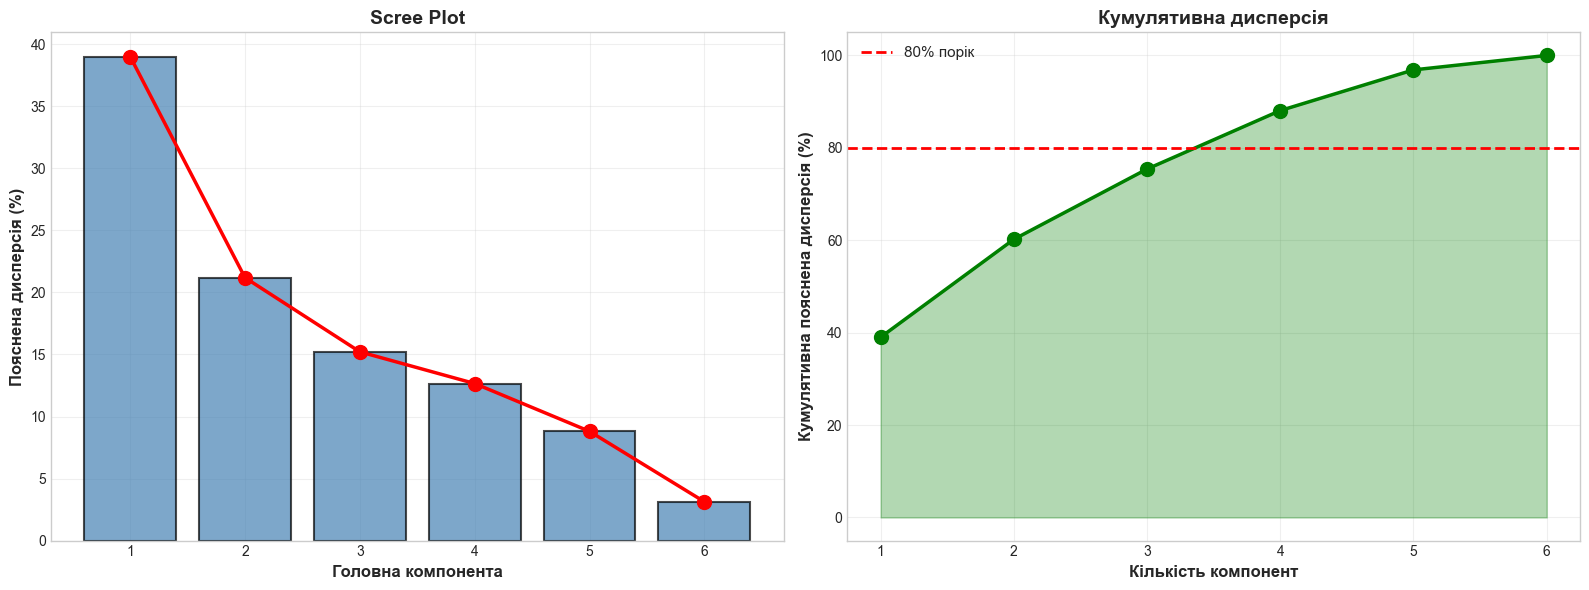

In [38]:
# Візуалізація результатів PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.bar(range(1, len(explained_variance) + 1), explained_variance * 100, 
        alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
ax1.plot(range(1, len(explained_variance) + 1), explained_variance * 100, 
         'ro-', linewidth=2.5, markersize=10)
ax1.set_xlabel('Головна компонента', fontweight='bold', fontsize=12)
ax1.set_ylabel('Пояснена дисперсія (%)', fontweight='bold', fontsize=12)
ax1.set_title('Scree Plot', fontweight='bold', fontsize=14)
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.grid(True, alpha=0.3)

# Кумулятивна дисперсія
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 
         'go-', linewidth=2.5, markersize=10)
ax2.fill_between(range(1, len(cumulative_variance) + 1), 
                 cumulative_variance * 100, alpha=0.3, color='green')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% порік')
ax2.set_xlabel('Кількість компонент', fontweight='bold', fontsize=12)
ax2.set_ylabel('Кумулятивна пояснена дисперсія (%)', fontweight='bold', fontsize=12)
ax2.set_title('Кумулятивна дисперсія', fontweight='bold', fontsize=14)
ax2.set_xticks(range(1, len(cumulative_variance) + 1))
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Навантаження показників на перші три головні компоненти:
                        PC1    PC2    PC3
Publications          0.583 -0.113 -0.157
R&D_pct_GDP           0.578  0.044 -0.138
STEM_pct              0.090  0.686  0.295
Patents_per_million   0.308  0.127  0.771
TEA_pct              -0.384 -0.300  0.443
New_Business_Density  0.276 -0.639  0.280


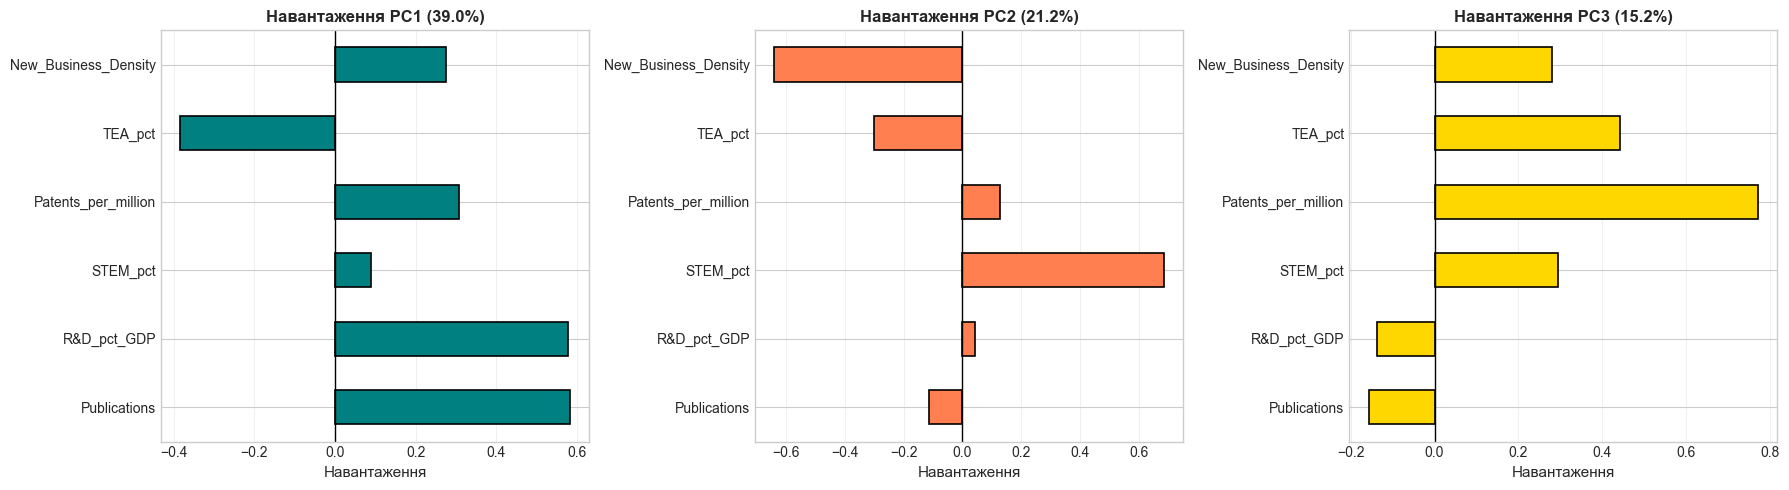


Інтерпретація:
  Навантаження показують внесок кожного показника у головну компоненту.
  Чим більше абсолютне значення, тим сильніше вплив показника на компоненту.


In [39]:
# Навантаження (loadings) показників на головні компоненти
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=num_cols
)

print("Навантаження показників на перші три головні компоненти:")
print("="*70)
print(loadings.round(4))
print("="*70)

# Візуалізація навантажень
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors_bars = ['teal', 'coral', 'gold']

for i, (ax, color) in enumerate(zip(axes, colors_bars), 1):
    loadings[f'PC{i}'].plot(kind='barh', ax=ax, color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(f'Навантаження PC{i} ({explained_variance[i-1]*100:.1f}%)', 
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('Навантаження', fontsize=11)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nІнтерпретація:")
print("  Навантаження показують внесок кожного показника у головну компоненту.")
print("  Чим більше абсолютне значення, тим сильніше вплив показника на компоненту.")

### 4.5 Збереження результатів

In [40]:
# Збереження результатів у CSV файли

# 1. Повні результати з індексами по роках
results = df_normalized[['Country', 'Code', 'Year', 'Innovation_Index_100']].copy()
results = results.rename(columns={'Innovation_Index_100': 'Innovation_Index'})
results.to_csv('innovation_index_results.csv', index=False)

# 2. Рейтинг країн
country_summary = pd.DataFrame({
    'Country': country_avg.index,
    'Average_Innovation_Index': country_avg.values,
    'Rank': range(1, len(country_avg) + 1)
})
country_summary.to_csv('country_ranking.csv', index=False)

# 3. Результати PCA
pca_summary = pd.DataFrame({
    'Component': [f'PC{i}' for i in range(1, len(explained_variance) + 1)],
    'Explained_Variance': explained_variance * 100,
    'Cumulative_Variance': cumulative_variance * 100
})
pca_summary.to_csv('pca_results.csv', index=False)

print("✓ Результати успішно збережено у файли:")
print("\n  1. innovation_index_results.csv")
print("     - Повні дані з індексами для кожної країни по роках")
print(f"     - Розмір: {results.shape[0]} рядків")
print("\n  2. country_ranking.csv")
print("     - Рейтинг країн за середнім індексом")
print(f"     - Кількість країн: {len(country_summary)}")
print("\n  3. pca_results.csv")
print("     - Результати аналізу головних компонент")
print(f"     - Кількість компонент: {len(pca_summary)}")

print("\n" + "="*70)
print("Перегляд рейтингу (топ-10):")
print("="*70)
print(country_summary.head(10).to_string(index=False))

✓ Результати успішно збережено у файли:

  1. innovation_index_results.csv
     - Повні дані з індексами для кожної країни по роках
     - Розмір: 1350 рядків

  2. country_ranking.csv
     - Рейтинг країн за середнім індексом
     - Кількість країн: 75

  3. pca_results.csv
     - Результати аналізу головних компонент
     - Кількість компонент: 6

Перегляд рейтингу (топ-10):
      Country  Average_Innovation_Index  Rank
  South Korea                    85.793     1
United States                    62.995     2
        Japan                    61.111     3
    Singapore                    57.697     4
  New Zealand                    55.791     5
       Sweden                    52.586     6
       Israel                    52.177     7
      Finland                    51.977     8
  Switzerland                    51.601     9
      Germany                    50.672    10


## Висновки

### У ході виконання практикуму було реалізовано наступні завдання:

**1. Огляд рішень**
- Проаналізовано міжнародні рейтинги інноваційної активності (GII, Bloomberg Innovation Index, EIS)
- Вивчено методи оцінки: агреговані показники, стандартизація, композитні індикатори, PCA

**2. Концептуальна модель та індикатори**
- Побудовано концептуальну модель: Інноваційна активність = f(Ресурси + Виходи + Екосистема)
- Підібрано 6 індикаторів з міжнародних джерел:
  - Ресурси: R&D витрати, STEM-випускники
  - Виходи: Наукові публікації, Патенти
  - Екосистема: TEA, Щільність нових бізнесів

**3. Статистичний аналіз**
- Обрано пул з **75 країн** за період **2005-2022 років (18 років)**
- Заповнено пропуски методом лінійної інтерполяції
- Виконано багатовимірний статистичний аналіз:
  - Описову статистику
  - Кореляційний аналіз (виявлено взаємозв'язки між показниками)
  - Аналіз розподілів та викидів
  - Часовий аналіз динаміки показників

**4. Модель композитного індексу**
- Виконано нормалізацію даних методом Z-score
- Побудовано зважений композитний індекс з розподілом:
  - Ресурси: 30% (R&D 15% + STEM 15%)
  - Виходи: 40% (Publications 20% + Patents 20%)
  - Екосистема: 30% (TEA 15% + New Business Density 15%)
- Створено рейтинг країн за інноваційною активністю
- Проведено PCA аналіз для виявлення структури даних
- Результати збережено у CSV файли для подальшого використання

### Основні результати:

1. Визначено лідерів інноваційної активності серед 75 країн світу
2. Виявлено структуру взаємозв'язків між різними аспектами інноваційної діяльності
3. Створено інструмент для об'єктивного порівняння інноваційного потенціалу країн
4. Проаналізовано динаміку інноваційної активності протягом 18 років
5. Побудовано робочу модель